# Collect and process PBMC3K single-cell RNA-seq dataset

**Authorship:**
Adam Klie, *01/22/2022*
***
**Description:**
Notebook to collect data for performing the autoencoder exercise outlined [here](https://www.notion.so/Autoencoder-Workshop-73d10091ac014f8c966a503e02759b11).
***
**Notes:**
 - You will need a kernel with [Scanpy](https://scanpy-tutorials.readthedocs.io/) installed. Follow the below instructions if you would like to build a kernel yourself, or simply use the following environment: `/cellar/users/aklie/opt/miniconda3/envs/single_cell_py` (see the autoencoder exercise instructions for setting up kernel using another user's environment).
 
```bash
conda create -n single_cell_py python=3.6 seaborn scikit-learn statsmodels numba
conda activate single_cell_py
conda install -c conda-forge python-igraph louvain leidenalg
conda install -c conda-forge python-igraph louvain leidenalg
pip install scanpy
pip install ipython ipykernel
python -m ipykernel install --user --name single_cell_py --display-name "Python 3 single_cell"
```
***

# Set-up

In [1]:
# The classics
import numpy as np
import pandas as pd

# Single cell analysis
import scanpy as sc
sc.settings.verbosity = 2
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

scanpy==1.7.2 anndata==0.7.8 umap==0.5.2 numpy==1.19.5 scipy==1.5.4 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.12.2


# PBMC3K w/ `scanpy` API
The data consist of 3k PBMCs from a Healthy Donor and are freely available from 10x Genomics. The following steps perform quality control filtering and identify the most variable genes to pass into the AE.

## <u> **Filtering** <u/>

In [ ]:
# Load the datasets
pbmc3k = sc.datasets.pbmc3k()

In [5]:
# Remove low counts genes and cells
sc.pp.filter_cells(pbmc3k, min_genes=200)
sc.pp.filter_genes(pbmc3k, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [6]:
# Calculate mitochondrial read fraction for each cell
pbmc3k.var['mt'] = pbmc3k.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(pbmc3k, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

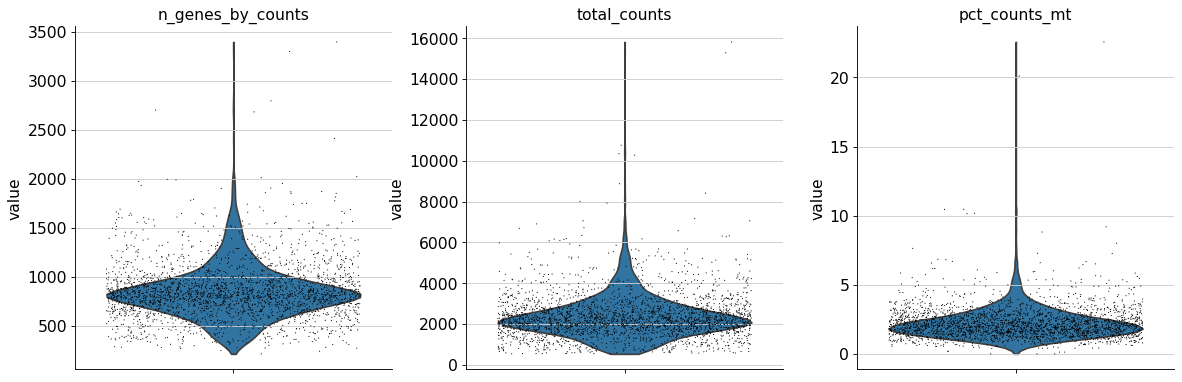

In [10]:
# Visualize total genes with counts, total counts per cell and mito count percentage
sc.pl.violin(pbmc3k, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [13]:
pbmc3k = pbmc3k[pbmc3k.obs.n_genes_by_counts < 2500, :]
pbmc3k = pbmc3k[pbmc3k.obs.pct_counts_mt < 5, :]

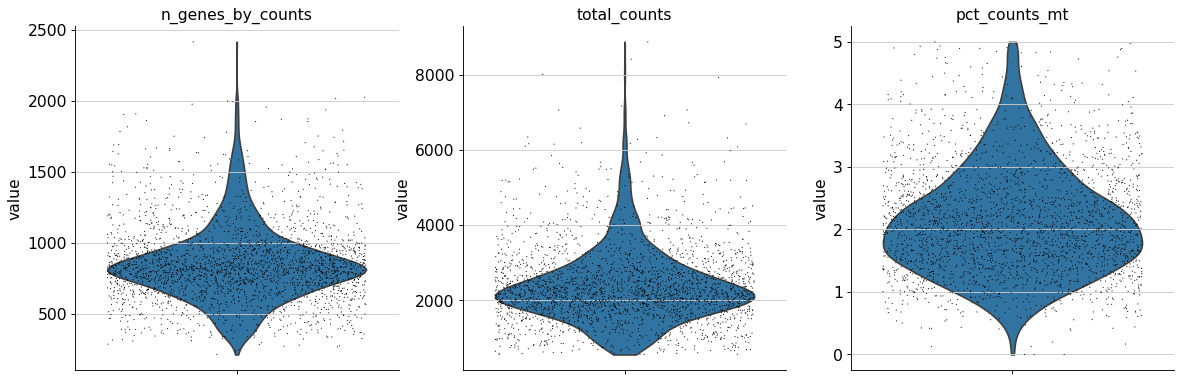

In [14]:
sc.pl.violin(pbmc3k, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

## <u> **Normalizing** <u/>

In [7]:
# Save the raw counts of the object at current state for later save
pbmc3k.layers['counts'] = pbmc3k.X.copy()

In [15]:
# Perform log-library normalization to aid in identification of most variable genes. Otherwise it will all just be the most highly expressed
sc.pp.normalize_total(pbmc3k, target_sum=1e4)
sc.pp.log1p(pbmc3k)

/cellar/users/aklie/opt/miniconda3/envs/single_cell_py/lib/python3.6/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)


## <u> **Selecting highly variable genes** <u/>

In [16]:
# ID the most highly variable genes
sc.pp.highly_variable_genes(pbmc3k, min_mean=0.0125, max_mean=3, min_disp=0.5)
pbmc3k.var["highly_variable"].value_counts()

extracting highly variable genes
    finished (0:00:00)


False    11876
True      1838
Name: highly_variable, dtype: int64

In [17]:
# Creat highly variable gene x cell matrix
m = pbmc3k.var["highly_variable"]
csr_mat = pbmc3k[:, pbmc3k.var["highly_variable"]].layers["counts"]

## <u> **Saving as tsv** <u/>

In [18]:
# Prep a dataframe to save
count_mat = csr_mat.transpose().toarray()
count_df = pd.DataFrame(data=count_mat, index=pbmc3k.var[m].index, columns=pbmc3k.obs.index, dtype=int)
count_df.index.name = "gene"
count_df.columns.name = "cell"

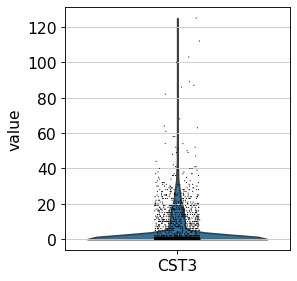

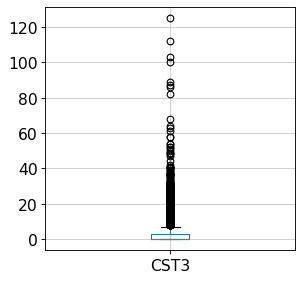

In [19]:
# Double check I didn't mess up the transformation
sc.pl.violin(pbmc3k, layer="counts", keys="CST3")
count_df.loc["CST3"].plot(kind="box")

In [20]:
# Save the dataframe as a tsv
count_df.to_csv("data/pbmc3k_raw_var_genes.tsv", sep="\t", index=True, header=True)

# Multiome scRNA-seq data from pancreatic islets

In [8]:
import collections
import scipy.sparse as sp_sparse
import tables
 
CountMatrix = collections.namedtuple('CountMatrix', ['feature_ref', 'barcodes', 'matrix'])
 
def get_matrix_from_h5(filename):
    with tables.open_file(filename, 'r') as f:
        mat_group = f.get_node(f.root, 'matrix')
        barcodes = f.get_node(mat_group, 'barcodes').read().astype('U32')
        data = getattr(mat_group, 'data').read()
        indices = getattr(mat_group, 'indices').read()
        indptr = getattr(mat_group, 'indptr').read()
        shape = getattr(mat_group, 'shape').read()
        matrix = sp_sparse.csc_matrix((data, indices, indptr), shape=shape)
         
        feature_ref = {}
        feature_group = f.get_node(mat_group, 'features')
        feature_ids = getattr(feature_group, 'id').read().astype('U32')
        feature_names = getattr(feature_group, 'name').read().astype('U32')
        feature_types = getattr(feature_group, 'feature_type').read().astype('U32')
        feature_ref['id'] = feature_ids
        feature_ref['name'] = feature_names
        feature_ref['feature_type'] = feature_types.astype('U32')
        tag_keys = getattr(feature_group, '_all_tag_keys').read().astype('U32')
        feature_ref["genome"] = getattr(feature_group, "genome").read().astype('U32')
        feature_ref["interval"] = getattr(feature_group, "interval").read().astype('U32')
         
        return CountMatrix(feature_ref, barcodes, matrix)

In [9]:
# Each sample takes about 10s to load in
grins_path = "/cellar/users/aklie/projects/GRINS/data/multiomic_islet_sampler/R207"
raw_matrix_h5 = "{}/raw_feature_bc_matrix.h5".format(grins_path)
raw_feature_bc_matrix = get_matrix_from_h5(raw_matrix_h5)
_, counts = np.unique(raw_feature_bc_matrix[0]["feature_type"], return_counts=True)
print("Number of unique barcodes: {}".format(len(set(raw_feature_bc_matrix[1]))))
print("Number of raw RNA features: {}".format(counts[0]))
print("Number of raw ATAC features: {}".format(counts[1]))

m = raw_feature_bc_matrix[0]["feature_type"] == 'Gene Expression'

R207_rna_pbmc3k = sc.AnnData(X=raw_feature_bc_matrix[2][m].T, obs=pd.DataFrame(index=raw_feature_bc_matrix[1]), var=pd.DataFrame(raw_feature_bc_matrix[0])[m].set_index("name"))
R207_rna_pbmc3k.var_names_make_unique()

Number of unique barcodes: 699071
Number of raw RNA features: 36601
Number of raw ATAC features: 108938


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [10]:
# Remove low counts genes and cells
sc.pp.filter_cells(R207_rna_pbmc3k, min_genes=200)
sc.pp.filter_genes(R207_rna_pbmc3k, min_cells=3)

filtered out 687975 cells that have less than 200 genes expressed
filtered out 9643 genes that are detected in less than 3 cells


In [11]:
# Calculate mitochondrial read fraction for each cell
R207_rna_pbmc3k.var['mt'] = R207_rna_pbmc3k.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(R207_rna_pbmc3k, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [12]:
# Save the raw counts of the object at current state for later save
R207_rna_pbmc3k.layers['counts'] = R207_rna_pbmc3k.X.copy()

In [13]:
# Perform normalization to aid in identification of most variable genes. Otherwised it will all just be the most highly expressed
sc.pp.normalize_total(R207_rna_pbmc3k, target_sum=1e4)
sc.pp.log1p(R207_rna_pbmc3k)

normalizing counts per cell
    finished (0:00:00)


In [14]:
# ID the most highly variable genes
sc.pp.highly_variable_genes(R207_rna_pbmc3k, min_mean=0.0125, max_mean=3, min_disp=0.5)
R207_rna_pbmc3k.var["highly_variable"].value_counts()

extracting highly variable genes
    finished (0:00:01)


False    22521
True      4437
Name: highly_variable, dtype: int64

In [15]:
# Save tsv file of highly variable gene x cell matrix
m = R207_rna_pbmc3k.var["highly_variable"]
csr_mat = R207_rna_pbmc3k[:, R207_rna_pbmc3k.var["highly_variable"]].layers["counts"]

In [16]:
# Prep a dataframe to save
count_mat = csr_mat.transpose().toarray()
count_df = pd.DataFrame(data=count_mat, index=R207_rna_pbmc3k.var[m].index, columns=R207_rna_pbmc3k.obs.index, dtype=int)
count_df.index.name = "gene"
count_df.columns.name = "cell"

... storing 'feature_type' as categorical
... storing 'genome' as categorical
... storing 'interval' as categorical


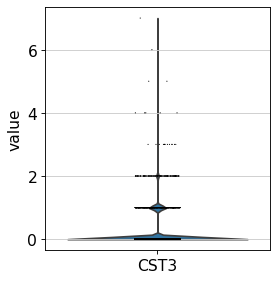

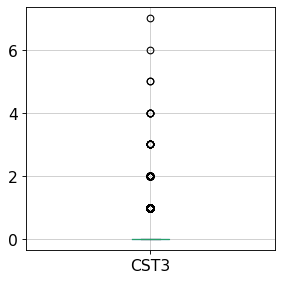

In [17]:
# Double check I didn't mess up the transformation
sc.pl.violin(R207_rna_pbmc3k, layer="counts", keys="CST3")
count_df.loc["CST3"].plot(kind="box")

In [18]:
count_df.to_csv("data/R207_rna_pbmc3k_raw_var_genes.tsv", sep="\t", index=True, header=True)

# References
1. [Preprocessing and clustering 3k PBMCs](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html#Preprocessing-and-clustering-3k-PBMCs)